# Image Search with Vector Databases

## Getting Semantic Vectors
We´re going to obtain a semantic vector from an image

In [1]:
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_experimental.open_clip import OpenCLIPEmbeddings
import glob
import base64

Initiate the OpenCLIPEmbeddings embedding model

In [2]:
embedding_model = OpenCLIPEmbeddings(
    model_name="ViT-B-32",  # Correct format
    checkpoint="openai",
    device="cpu"
)

Retrieve Image File Paths

In [3]:
# The glob.glob function retrieves all .jpeg images in the ../images/ directory
paths = glob.glob('./images_data/*.jpeg', recursive=True)

print("Total Images:", len(paths))

Total Images: 10


## Storing Image Vectors
Store image vectors in a FAISS vector database using OpenCLIP embeddings

### Encode Images in Base64
Since LLMs cannot process raw images, we convert each image into a base64-encoded string.


The encode_image function:

⦁	Opens the image file

⦁	Reads the image as bytes

⦁	Encodes it into a UTF-8 base64 string

In [4]:
def encode_image(path):
    with open(path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

### Convert Images into Documents
We iterate over all image paths and create a LangChain Document for each:

⦁	page_content → Stores the base64-encoded image.

⦁	metadata → Stores the original image file path.


In [5]:
lc_docs = []

for path in paths:
    doc = Document(
        page_content=encode_image(path),
        metadata={
            'source': path
        }
    )
    lc_docs.append(doc)


### Store Documents in FAISS
Now that we have our documents, we store them in a FAISS vector database. We use OpenCLIPEmbeddings to generate the embeddings.


In [6]:
vector_store = FAISS.from_documents(lc_docs, embedding=embedding_model)

print("FAISS vector store created.")
print("FAISS index size:", vector_store.index.ntotal)

FAISS vector store created.
FAISS index size: 10


### Convert FAISS into a Retriever
Turn the FAISS vector store into a retriever to enable similarity search:


In [7]:
retriever = vector_store.as_retriever()
print("Retriever initialized successfully.")

Retriever initialized successfully.


### Retrieve Similar Images
Pass an encoded image to the retriever and fetch the top 4 most similar images to cat_1.


In [9]:
docs = retriever.invoke(encode_image("./images_data/cat_1.jpeg"), k=4) 


### Display Results
To verify the retrieved images, we print their file paths:


In [10]:
for doc in docs:
    print(doc.metadata)

{'source': './images_data/cat_1.jpeg'}
{'source': './images_data/cat_2.jpeg'}
{'source': './images_data/cat_4.jpeg'}
{'source': './images_data/cat_5.jpeg'}


✔ The first result is cat_1 itself.

✔ The following results are cat_2, cat_4, and cat_5, indicating high similarity.

## Finding the Dog Most Similar to a Cat
The goal is to determine which dog image is the most similar to cats, based on our image embedding model.

### Concept Behind the Approach
The basic idea is:

⦁	Find the dog image that retrieves the most cat images when queried.

⦁	Weight results inversely by rank (higher-ranked cat results contribute more).

⦁	Compare all dogs and assign them a "cat similarity score."


### Solution Overview

⦁	Retrieve all dog image paths.

⦁	For each dog image, retrieve its most similar images.

⦁	Count how many of the retrieved images are cats.

⦁	Assign an inverse-weighted score based on ranking.

⦁	Determine the dog with the highest "cat similarity score."


### Retrieve all dog image paths

In [11]:
dog_paths = glob.glob('./images_data/dog*.jpeg', recursive=True)

### Find and Score Each Dog
⦁	Loop through all dog images.

⦁	Retrieve the top matches for each dog.

⦁	Count how many cat images appear in the top results.

⦁	Assign an inverse-weighted score (higher-ranked cats contribute more).


In [14]:
dog_to_cat = {}

for dog_pic in dog_paths:
    docs = retriever.invoke(encode_image(dog_pic))  # Retrieve similar images
    cats_retrieved = 0
    
    for i, doc in enumerate(docs):
        if "cat" in doc.metadata["source"]:  # Check if the retrieved image is a cat
            cats_retrieved += 4 - i  # Inverse-weighting based on rank

    dog_to_cat[dog_pic] = cats_retrieved  # Store results

### Display Results
The final dictionary dog_to_cat stores the similarity score for each dog image:

In [13]:
dog_to_cat

{'./images_data/dog_3.jpeg': 1,
 './images_data/dog_4.jpeg': 1,
 './images_data/dog_5.jpeg': 2,
 './images_data/dog_1.jpeg': 0,
 './images_data/dog_2.jpeg': 1}

This suggests that the OpenCLIP embeddings effectively differentiate between dog and cat images.

- dog_5.jpeg has the highest score (2), meaning it retrieved more cat images than the other dog images.

- This might indicate that dog_5.jpeg shares some visual features with cat images (e.g., posture, lighting, color, background).

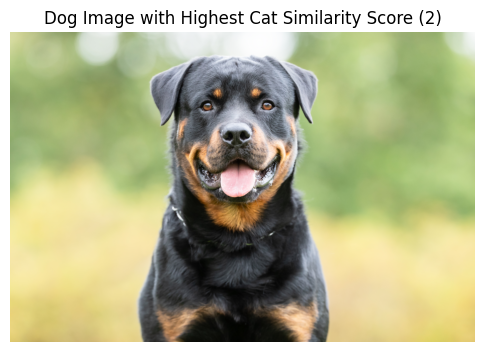

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

# Find the dog image with the highest score
best_dog_image = max(dog_to_cat, key=dog_to_cat.get)
highest_score = dog_to_cat[best_dog_image]

# Load and display the image
image = Image.open(best_dog_image)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Dog Image with Highest Cat Similarity Score ({highest_score})")
plt.show()


### Conclusion: 
- The OpenCLIP model seems to be performing well in distinguishing dog images from cat images, as most retrievals favor the same class.

- Some images (like dog_5.jpeg) may contain overlapping features between the two classes, leading to minor misclassifications in similarity search.

- If the goal is strict classification, further fine-tuning of the embedding model or additional preprocessing (e.g., image augmentation or feature engineering) may help improve separation between classes.

## Querying Images with Text
Allowing text-based queries to retrieve relevant images. This enables us to search for images using natural language descriptions.


### Process Image and Text Data for Querying

Function to Resize Images (for compatibility with OpenAI models)
This function:

⦁	Converts Base64 back to an image.

⦁	Resizes it to 128×128 pixels.

⦁	Encodes it back to Base64 for further processing.


In [24]:
from io import BytesIO
from PIL import Image

def resize_base64_image(base64_string, size=(128, 128)):
    img_data = base64.b64decode(base64_string)
    img = Image.open(BytesIO(img_data))

    resized_img = img.resize(size, Image.LANCZOS)

    buffered = BytesIO()
    resized_img.save(buffered, format=img.format)

    return base64.b64encode(buffered.getvalue()).decode("utf-8")


Function to Check if a String is in Base64 Format

In [25]:
def is_base64(s):
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


Function to Separate Image and Text Data

This function:

⦁	Loops through retrieved documents.

⦁	Identifies images (Base64 format).

⦁	Resizes images before storing them.

⦁	Separates text from images.


In [26]:
def split_image_text_types(docs):
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract content from Document
        if is_base64(doc):
            images.append(resize_base64_image(doc))  # Resize before storing
        else:
            text.append(doc)
    return {"images": images, "texts": text}


### Construct a Multimodal RAG Query System

Import Additional LangChain Modules

⦁	HumanMessage → Represents user inputs in the chat.

⦁	RunnableLambda → Allows for function execution in LangChain.

⦁	ChatOpenAI → Enables interaction with GPT-4o-mini.


In [20]:
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os


Function to Format the Prompt for GPT-4o

This function:

⦁	Formats retrieved text into a structured prompt.

⦁	Adds images to the prompt (if present).

⦁	Incorporates user-provided keywords.


In [27]:
def prompt_func(data_dict):
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Add image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Add the text message
    text_message = {
        "type": "text",
        "text": (
            "As an animal lover, your task is to analyze and interpret images of cute animals, "
            "Please use your extensive knowledge and analytical skills to provide a "
            "summary that includes:\n"
            "- A detailed description of the visual elements in the image.\n"
            f"User-provided keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]


## Define the RAG Pipeline

Load GPT-4o-mini Model

In [28]:
# Load environment variables from .env
load_dotenv()

#Retrieve API key
openai_api_key = os.getenv("OPENAI_API_KEY")

#Initialize the OpenAI model with the API key
foundation = ChatOpenAI( 
temperature=0, 
model="gpt-4o-mini", 
max_tokens=1024, 
openai_api_key=openai_api_key 
)


Define the Chain

This chain:

⦁	Retrieves the most relevant images.

⦁	Splits retrieved data into image and text.

⦁	Formats the results into a structured query.

⦁	Passes the formatted query to GPT-4o for response generation.


In [29]:
chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(prompt_func)
    | foundation
    | StrOutputParser()
)


## Query for an Image Using Text
Let’s search for an image of a rottweiler using a text query.

In [30]:
chain.invoke("rottweiler")

"The image features a Rottweiler, a breed known for its strong build and confident demeanor. Here’s a detailed description of the visual elements:\n\n- **Subject**: The Rottweiler is the focal point of the image, displaying a friendly expression with its mouth slightly open, showcasing its tongue. This gives it a playful and approachable appearance.\n  \n- **Coloration**: The dog has a distinct black coat with tan markings on its face, chest, and legs, which is characteristic of the breed. The contrast between the black and tan colors is striking.\n\n- **Background**: The background is blurred, suggesting a natural outdoor setting, possibly a park or garden. The soft greens and yellows create a warm, inviting atmosphere that complements the dog's colors.\n\n- **Posture**: The Rottweiler is standing upright, exuding confidence and alertness. Its ears are perked up, indicating curiosity and engagement with its surroundings.\n\n- **Lighting**: The lighting appears natural, likely from sun

Retrieve Images Similar to "Rottweiler"

In [31]:
docs = retriever.invoke("rottweiler", k=4)

for doc in docs:
    print(doc.metadata)


{'source': './images_data/dog_5.jpeg'}
{'source': './images_data/dog_4.jpeg'}
{'source': './images_data/dog_3.jpeg'}
{'source': './images_data/cat_2.jpeg'}


✔ The first result is dog_5 indicating high similarity with "Rottweiler"

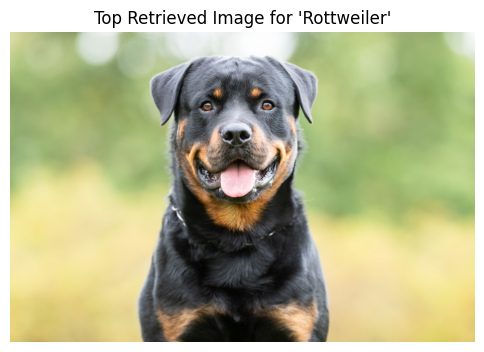

In [33]:
# Extract the first retrieved image path
first_image_path = docs[0].metadata['source']

# Load and display the image
image = Image.open(first_image_path)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")  # Remove axis for a clean display
plt.title("Top Retrieved Image for 'Rottweiler'")
plt.show()


## Detecting Anomalies in Embeddings

let’s query the vector database to check for unexpected retrievals.

### Expected Correct Matches

***Example 1***: Searching for "Rottweiler" (dog_5)


In [34]:
docs = retriever.invoke("rottweiler", k=4)  # Search for "Rottweiler"

for doc in docs:
    print(doc.metadata)


{'source': './images_data/dog_5.jpeg'}
{'source': './images_data/dog_4.jpeg'}
{'source': './images_data/dog_3.jpeg'}
{'source': './images_data/cat_2.jpeg'}


✅ ***Correct result*** → dog_5 (the Rotweiller) is the top match.

***Example 2***: Searching with an Image (cat_1)

In [35]:
docs = retriever.invoke(encode_image("./images_data/cat_1.jpeg"), k=4)

for doc in docs:
    print(doc.metadata)


{'source': './images_data/cat_1.jpeg'}
{'source': './images_data/cat_2.jpeg'}
{'source': './images_data/cat_4.jpeg'}
{'source': './images_data/cat_5.jpeg'}


✅ ***Correct result*** → cat_1 is the top match.

***Example 3***: Searching for "gray cat with long hair in a field" (cat_2)

In [36]:
docs = retriever.invoke("gray cat with long hair in a field", k=4)

for doc in docs:
    print(doc.metadata)


{'source': './images_data/dog_3.jpeg'}
{'source': './images_data/dog_4.jpeg'}
{'source': './images_data/dog_5.jpeg'}
{'source': './images_data/dog_2.jpeg'}


❌ ***Anomaly***: The top result is dog_3 instead of cat_2.

 💡 ***Possible Fix:*** Improve the embedding model or fine-tune it with better training data.


***Example 4***: Searching for "golden retriever playing with an orange ball" (dog_2)

In [38]:
docs = retriever.invoke("golden retriever playing with orange ball", k=4)

for doc in docs:
    print(doc.metadata)


{'source': './images_data/dog_5.jpeg'}
{'source': './images_data/dog_4.jpeg'}
{'source': './images_data/dog_3.jpeg'}
{'source': './images_data/cat_3.jpeg'}


❌ ***Anomaly***: The top result is dog_5 instead of dog_2.

 💡 ***Possible Fix:*** Improve the embedding model or fine-tune it with better training data.


***Example 5:*** Searching for "golden retriever in a field with a sunny blurred background" (dog_4)

In [40]:
docs = retriever.invoke("golden retriever in field with a sunny blurred background", k=4)

for doc in docs:
    print(doc.metadata)


{'source': './images_data/dog_5.jpeg'}
{'source': './images_data/dog_4.jpeg'}
{'source': './images_data/dog_3.jpeg'}
{'source': './images_data/dog_1.jpeg'}


❌ ***Anomaly***: The top result is dog_5 instead of dog_4. But dog_4 is the second match.

 💡 ***Possible Fix:*** Improve the embedding model or fine-tune it with better training data.